In [1]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.metrics import mean_squared_error, structural_similarity as ssim
import torch
import lpips

IMG_DIR = "generated_images_21_ad5"

# Load the images into a numpy array; let's assume they are png
img_paths = [os.path.join(IMG_DIR, f) for f in os.listdir(IMG_DIR) if f.endswith('.png')]

In [ ]:
# Function to compute distances between consecutive images, i.e. image 0->1, 1->2, etc.
# We accept a kwarg specifying the metric to use.
# Acceptable choices are "mse", "lpips", and "ssim".
def compute_distances(img_paths, metric='mse'):
    if metric == 'lpips':
        loss_fn = lpips.LPIPS(net='vgg')

    img0 = np.array(Image.open(img_paths[0]))
    dists = []
    for idx in range(1, len(img_paths)):
        img1 = np.array(Image.open(img_paths[idx]))
        if metric == 'mse':
            dists.append(mean_squared_error(img0 / 255.0, img1 / 255.0))
        elif metric == 'lpips':
            img0t = torch.tensor(img0).permute(2, 0, 1).unsqueeze(0).to(torch.float32) / 255.0
            img1t = torch.tensor(img1).permute(2, 0, 1).unsqueeze(0).to(torch.float32) / 255.0
            distance = loss_fn(img0t, img1t).item()  # Compute LPIPS distance
            dists.append(distance)
        #elif metric == 'ssim':
        #    return np.array([ssim(images[i], images[i + 1], multichannel=True) for i in range(len(images) - 1)])
        else:
            raise ValueError("Unsupported metric: {}".format(metric))
        
        img0 = img1

    return torch.tensor(dists)

In [12]:
distances_mse = compute_distances(img_paths, metric='mse')
#distances_ssim = compute_distances(img_paths, metric='ssim')
distances_lpips = compute_distances(img_paths, metric='lpips')

print(f"Mean MSE distance: {distances_mse.mean()}")
#print(f"Mean SSIM distance: {distances_ssim.mean()}")
print(f"Mean LPIPS distance: {distances_lpips.mean()}")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/mmattb/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


AttributeError: 'list' object has no attribute 'mean'

In [14]:

print(f"Mean MSE distance: {distances_mse.mean()}")
#print(f"Mean SSIM distance: {distances_ssim.mean()}")
print(f"Mean LPIPS distance: {distances_lpips.mean()}")

Mean MSE distance: 0.0012362307096864087
Mean LPIPS distance: 0.045623838901519775


tensor([0.0000, 0.0198, 0.0000,  ..., 0.0119, 0.0213, 0.0249])


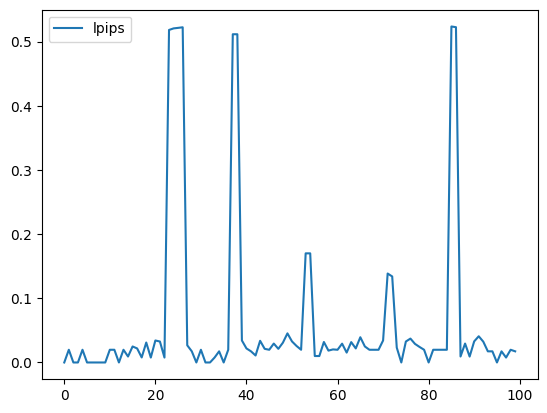

In [15]:
# print(distances_mse)
print(distances_lpips)

plt.plot(distances_lpips[:100], label="lpips")
# plt.plot(distances_lpips, label="mse")
plt.legend()
plt.show()

In [16]:
# Let's run mse without summing across pixels and look at the distribution of pixel-wise distances.
# Here we don't want to mean or sum across pixels. Instead we want to compute the pixel distances
# and then graph a histogram.  Let's write a function which does that for an arbitrary image pair.

def compute_pixelwise_mse(img0, img1):
    return np.mean((img0 - img1) ** 2, axis=-1)

def plot_pixelwise_mse_histogram(img0path, img1path):
    img0 = np.array(Image.open(img0path))
    img1 = np.array(Image.open(img1path))
    pixelwise_dists = compute_pixelwise_mse(img0, img1)
    plt.hist(pixelwise_dists, bins=50)
    plt.xlabel("Pixel-wise MSE")
    plt.ylabel("Frequency")
    plt.title("Histogram of Pixel-wise MSE")
    plt.show()


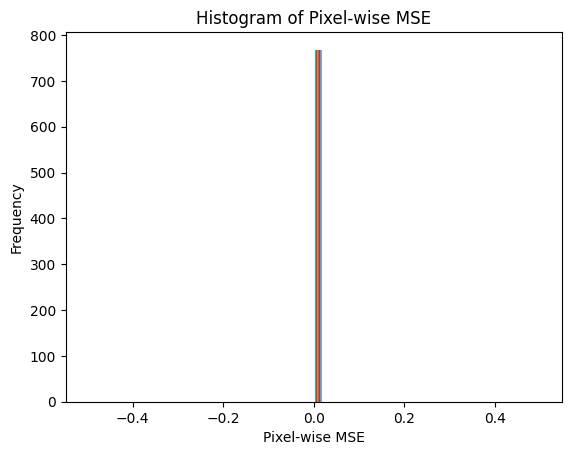

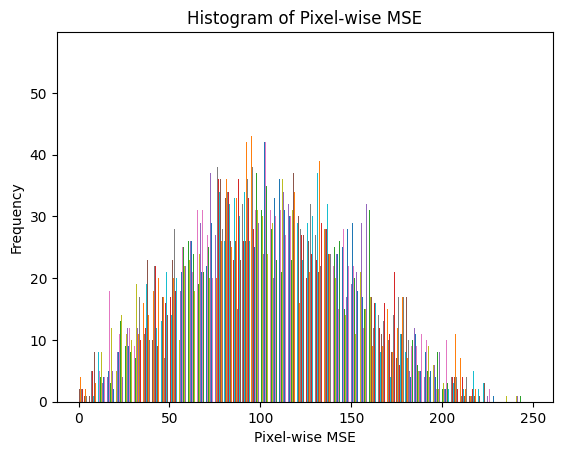

In [17]:
plot_pixelwise_mse_histogram(img_paths[0], img_paths[1])
plot_pixelwise_mse_histogram(img_paths[23], img_paths[24])